<center><h1>ЛР 4 - Методы сопряжённых направлений</h1><center>
<center>Леховицкий Дмитрий, ст. гр. ПМ-15-1<center>
<center>Вариант №7<center>

In [1]:
# для вычислений
import numpy as np
from numpy import dot
from numpy import array
from numpy.linalg import inv
from scipy.optimize import minimize 
from scipy.optimize import OptimizeResult
from scipy.optimize import minimize_scalar

# для построения графиков
%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("seaborn")
plt.rc("text", usetex=True)
plt.rc("font", serif="serif")

In [2]:
# непосредственно построение графиков
def plot_surface(ff, xx, yy):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, ff, alpha=0.6)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$f(x_1, x_2)$')
    return fig, ax

# пора всё это дело уже в отдельный файл вынести
def plot_contour(ff, xx, yy, levels):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    CS = ax.contour(xx, yy, ff, levels, colors=sns.color_palette("Blues"), alpha=0.6)
    ax.set_aspect(1)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.clabel(CS, levels, fmt="%.2f")
    return fig, ax

## Постановка задачи и описание метода

Продолжаем с безусловной оптимизацией, как и раньше, у нас стоит задача 

$$f(\mathbf{x}) \to \min_{\mathbf{x}\in \Omega}.$$

Сегодня мы рассмотрим ещё одну группу методов, использующих производные функции $f$, основная идея которых заключается в том, что направления, по которым строится минимизирующая последовательность $\{\mathbf{x}^{(k)}\}_{k=1}^{\infty}$, являются сопряжёнными (некое обобщение ортогональности) друг другу. Два вектора $\mathbf{x}$ и $\mathbf{y}$ называются сопряжёнными по отношению к матрице $\mathbf{H}$, если $\mathbf{x}^T \mathbf{H} \mathbf{y} = 0$.

Изначально метод строится для квадратичных функций вида $f(\mathbf{x}) = a + \mathbf{b}^T\mathbf{x} + \dfrac{1}{2} \mathbf{x}^T \mathbf{H} \mathbf{x}$. Для них метод гарантированно сходится за $n$ шагов ($n$ - размерность пространства).

Направление каждого следующего шага $\mathbf{s}^{(k+1)}$ строится как линейная комбинация предыдущего направления $\mathbf{s}^{(k)}$ и направления наискорейшего спуска $-\nabla f(\mathbf{x^{(k+1)}})$:
$$\mathbf{s}^{(k+1)} = -\nabla f(\mathbf{x}^{(k+1)}) + \omega_{k+1} \mathbf{s}^{(k)}.$$



В качестве стартового направления выбирается значение антиградиента в начальной точке - $\mathbf{s}^{(0)} = -\nabla f(\mathbf{x}^{(0)})$, а вес $\omega_{k+1}$ выбирается так, чтобы направления $\mathbf{s}^{(k+1)}$ и $\mathbf{s}^{(k)}$ были сопряжёнными. Для квадратичной функции достаточно положить 
$$\omega_k = \frac
    {\nabla^T f(\mathbf{x}^{(k)}) \nabla f(\mathbf{x}^{(k)})}
    {\nabla^T f(\mathbf{x}^{(k-1)}) \nabla f(\mathbf{x}^{(k-1)})}.
$$

Более того, можно показать, что при таком построении градиенты в точках минимизирующей последовательности являются взаимно ортгональными.

Записав эту идею в виде алгоритма, получим метод Флетчера-Ривза. С успехом применить его к неквадратическим функциям, однако, не получится. 

Немного модифицируем формулу для веса, получим метод Полака-Райбера, которую и будем применять далее:

$$\omega_k = \frac
    {\nabla^T f(\mathbf{x}^{(k)}) \left( \nabla f(\mathbf{x}^{(k)}) - \nabla f(\mathbf{x}^{(k-1)}) \right) }
    {\nabla^T f(\mathbf{x}^{(k-1)}) \nabla f(\mathbf{x}^{(k-1)})}.
$$

## Пример и реализация

В качестве примера возьмём следующую функцию: $$f(\mathbf{x}) = x_1^3 + 8x_2^3 - 6x_1 x_2 + 1,$$ а в качестве начальной точки возьмём точку $\mathbf{x}^{(0)} = [2, 1]^T$.

In [3]:
x0 = np.array([2, 1])

def f(x):
    x1, x2 = x
    return x1**3 + 8*x2**3 - 6*x1*x2 + 1 

def grad_f(x):
    x1, x2 = x
    grad = np.zeros_like(x)
    grad[0] =  3*x1**2 - 6*x2
    grad[1] = 24*x2**2 - 6*x1
    return grad

In [4]:
delta = 0.025
x1 = np.arange(-0.5, 3+delta, delta)
x2 = np.arange(-0.5, 1.5+delta, delta)
xx1, xx2 = np.meshgrid(x1, x2)
ff = f([xx1, xx2])

<IPython.core.display.Javascript object>


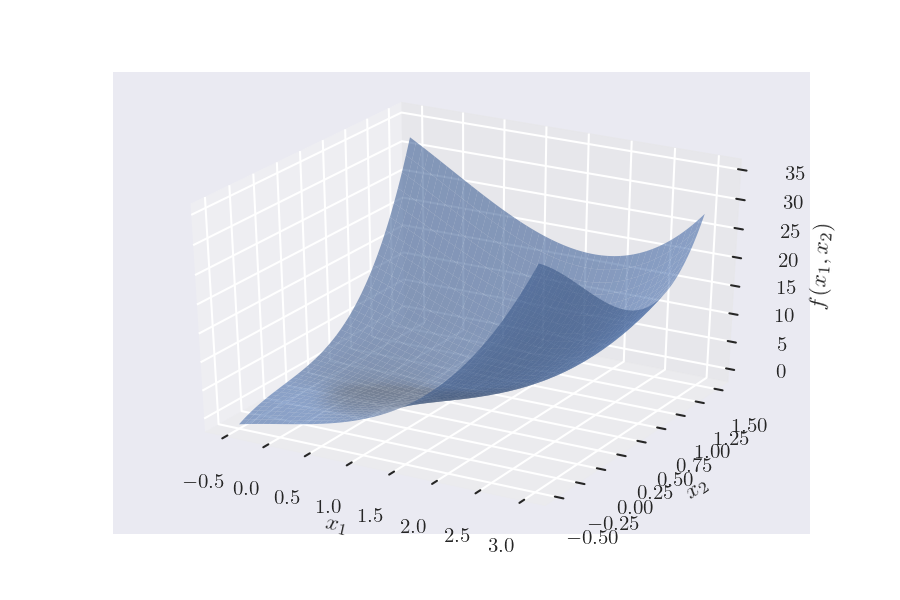

In [5]:
plot_surface(ff, xx1, xx2);

<IPython.core.display.Javascript object>


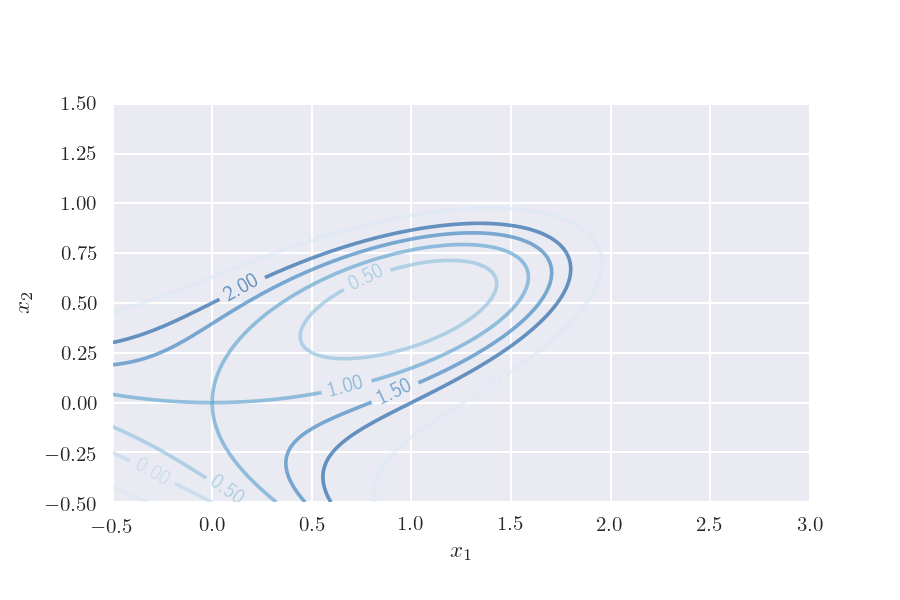

In [6]:
plot_contour(ff, xx1, xx2, levels=[-1, 0, 0.5, 1, 1.5, 2., 3]);

Ниже приведена функция, реализовывающая метод сопряжённых направлений:

In [7]:
def conjugate_gradient(func, x0, jac, tol, alpha=0.05, args=(), **options):
    k = 0
    X = [x0]  
    F = [func(x0)] 
    J = jac(x0)
    S = [-J]
    
    X.append(X[k] + alpha*S[k])
    
    while np.linalg.norm(J) >= tol:
        k += 1
        # find the conjugate direction
        J_next = jac(X[k])
        w = dot(J_next, J_next - J) / dot(J, J)
        S.append(-J_next + w*S[k-1])
        # make the step 
        X.append(X[k] + alpha*S[k])
        # store the results 
        F.append(func(X[k+1]))
        J = J_next
        
    return OptimizeResult(
        x=X[-1], fun=F[-1], jac=J[-1],
        x_hist=np.c_[X].T, f_hist=array(F), 
        nit=k+1)

In [8]:
%timeit minimize(f, x0, method=conjugate_gradient, jac=grad_f, tol=0.001, options={'alpha': 0.0625})

1.52 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
res = minimize(f, x0, method=conjugate_gradient, jac=grad_f, tol=0.001, options={'alpha': 0.0625})
x1_hist, x2_hist = res.x_hist
print("Optimal point: (%.6f, %.6f).\nOptimal value: %.6f." % (res.x[0], res.x[1], res.fun))
print("Number of iterations for conjugate gradient method: %d." % res.nit)

Optimal point: (0.999859, 0.499950).
Optimal value: 0.000000.
Number of iterations for conjugate gradient method: 28.


<IPython.core.display.Javascript object>


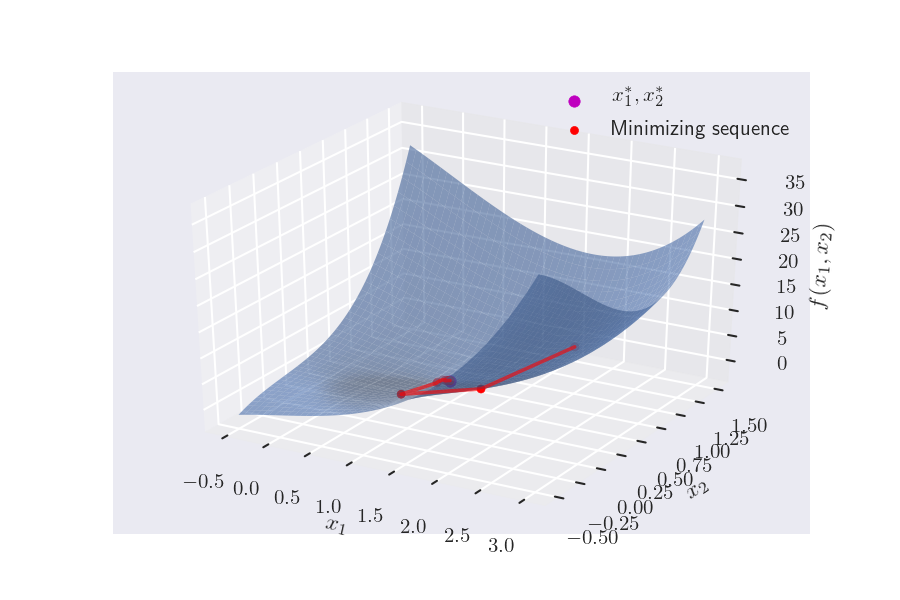

In [10]:
fig, ax = plot_surface(ff, xx1, xx2);
ax.scatter(res.x[0], res.x[1], f([res.x[0], res.x[1]]), c='m', s=30, label='$x_1^{*}, x_2^{*}$')
ax.scatter(x1_hist, x2_hist, f([x1_hist, x2_hist]), c='r', s=15, label='Minimizing sequence')
ax.plot(x1_hist, x2_hist, f([x1_hist, x2_hist]), c='r', alpha=0.6)
ax.legend();

<IPython.core.display.Javascript object>


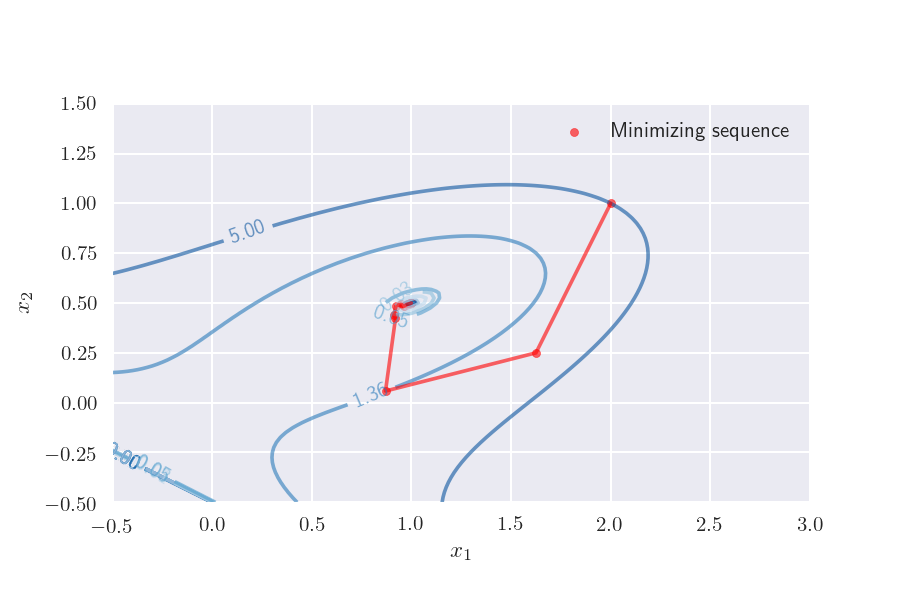

In [11]:
fig, ax = plot_contour(ff, xx1, xx2, levels=np.sort(res.f_hist)[10:])
ax.scatter(x1_hist, x2_hist, c='r', alpha=0.6, s=15, label='Minimizing sequence')
ax.plot(x1_hist, x2_hist, c='r', alpha=0.6)
ax.legend();

## Мини-вывод

Как видим, минимум функции метод нашёл достатоно хорошо.

Сравнивая с другими группами методов, которые мы применяли для одной и той же функции, можно сказать, что скорость выполнения соизмерима со скоростью градиентных методов (как и количество итераций), однако методы второго порядка всё же существенно превзошли обе эти группы (хотя оптимизация величины шага $\alpha$ могла ускорить процесс, в нашем случае использовался фиксированный шаг, при некоторых значениях которого метод даже не сходился).

https://en.wikipedia.org/wiki/Nonlinear_conjugate_gradient_method